## Handle Numerical Variable Transformation, using Log Transformer, Reciprocal Transformer, Power Transformer, Box-Cox and Yeo Johnson Transformer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline
from feature_engine.imputation import DropMissingData

**To determine which transformation to use for normalizing the data**

* 📈 `Right-skewed (long tail on the right)? → Try log, square root, or Box-Cox`
* 📉 `Left-skewed (long tail on the left)? → Try reciprocal, log of max - x, or Yeo-Johnson`
* ⚖️ `Symmetrical or normal-looking? → No need to transform`

**Additional Notes**
* `log` - If right skew has long tail. Box-Cox can be used alternatively. However, Box-Cox doesn't offer interpretability.
* `reciprocal` - If left skew has long tail, Inverse relationship (more speed = less time), Interpretability & Simplicity. Otherwise, Yeo_johnson can be used instead.


**Quick Comparison** *

  **-Method	           -Works with Negatives?	  -Automatic λ	  -Normalizes?	 -Scales?**
* log(x)	               ❌ No	                  ❌ No	        👍 Yes	     ❌ No
* Box-Cox	               ❌ No (x > 0 only)	      ✅ Yes	    👍 Yes	     ❌ No
* Yeo-Johnson	           ✅ Yes	                  ✅ Yes	    👍 Yes	     ❌ No
* PowerTransformer	       ✅ Yes (w/ YJ)	          ✅ Yes	    👍 Yes	     ✅ Yes


The techniques presented here transform numerical variables considering multiple mathematical transformations. The idea is to transform the variable distribution, ideally to become close to a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). We will study the following transformers:
* LogTransformer
* ReciprocalTransformer
* PowerTransformer
* BoxCoxTransformer
* YeoJohnsonTransformer

We will do exercises with all of the transformers. You don't have to memorise the specific mathematical function for each transformer. Instead, you should be aware that we apply mathematical functions to numerical data. Later on, we will show a custom function that displays a report on numerical transformations, giving you criteria to select the most suitable transformer for your data.

* We will use the pingouin package to run a Q-Q plot to visually check how close to the normal distribution a given variable is.


In [ ]:
import pingouin as pg

## Log Transfer

Why Use Log Transfer?
Log transformations are typically used for:

- **Reducing skewness:** Many real-world datasets have right-skewed distributions (i.e., long tail on the right). Log transformation can make the data more normally distributed, which is ideal for many ML algorithms.
- **Compressing range:** Log transformation compresses large values and expands small values, making the data more manageable and reducing the impact of outliers.
- **Stabilizing variance:** It can make the variance more consistent (homoscedasticity), which is important for models like linear regression.

When Not to Use It
- If the feature has negative or zero values (without handling them properly), log transformation will fail.
- If the model you’re using is robust to skew (like tree-based models), log transformation may not be necessary.

It applies the [natural logarithm](https://en.wikipedia.org/wiki/Natural_logarithm) (base e) or the base 10 logarithm to numerical variables. The function documentation is [here](https://feature-engine.trainindata.com/en/latest/user_guide/transformation/LogTransformer.html)
* The transformer, as we may expect, can't handle zero or negative values
* The arguments are the `variables` you want to apply the method to. In cases where you don't pass in a list of variables, the transformer considers all numerical variables. The next argument is `base` (either 'e' or '10').

In [ ]:
from feature_engine import transformation as vt

We will consider the Boston dataset from [scikit learn datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html). It shows house prices in Boston.
* We used four lines of code to unpack the dataset into a format to reach a DataFrame with all the features and the target variable. In the future lesson, we will investigate how to use sklearn functionalities. For now, we need its dataset.
* For this exercise, we are not interested in making sense of the variable's meaning and business impact. We're looking for numerical variables for handling transformation. we will consider only a subset of the variables.

In [26]:
boston_data = pd.read_csv('housing.csv')
df = pd.DataFrame(data=boston_data)
df['target'] = pd.Series(boston_data.target)

df = df.filter(['DIS','LSTAT', 'target'])
df.head()

,DIS,LSTAT,target
0,4.0900,4.98,24.0
1,4.9671,9.14,21.6
2,4.9671,4.03,34.7
3,6.0622,2.94,33.4
4,6.0622,5.33,36.2


We assess the histogram and QQ plot by looping over the variables. We create custom functions for this task since we will repeat it across different transformers. The first will calculate skewness and kurtosis. The second plots a histogram and QQ plot for a given numerical variable.

A quick recap
* **Skewness** is the asymmetry of the data. A distribution is symmetric when it looks the same to the left and right of the centre point. It is horizontally mirrored. Positive Skewness happens when the tail on the right side is longer. Negative skewness is the opposite.
* **Kurtosis** relates to the tails of the distribution. It is a measure of outliers in the distribution. A negative kurtosis indicates the distribution has thin tails. `Positive kurtosis indicates that the distribution is peaked and has thick tails`.
* **QQ plot** helps you check if the data is approximately normally distributed. If the points closely follow a straight line, the data is close to normal. If they deviate significantly, the data may not follow a normal distribution.

*** DIS ***


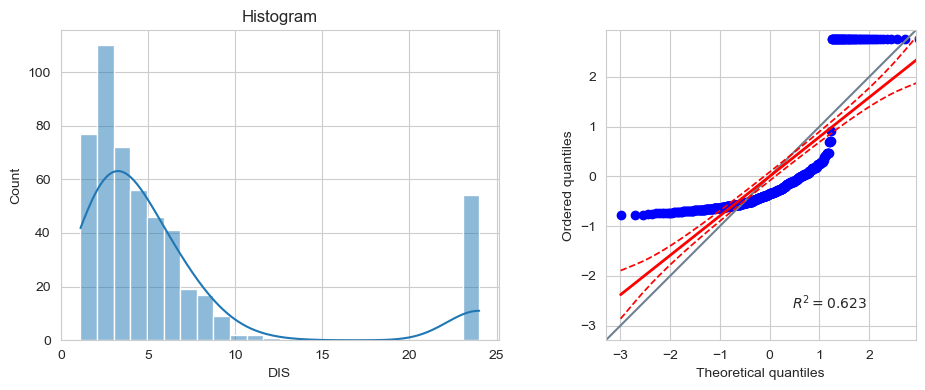

before apply transformation  | skewness: 2.14 | kurtosis: 3.26


*** LSTAT ***


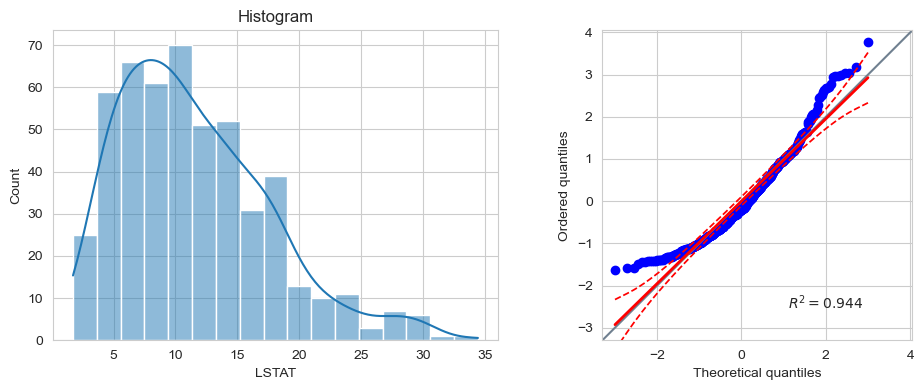

before apply transformation  | skewness: 0.9 | kurtosis: 0.65


*** target ***


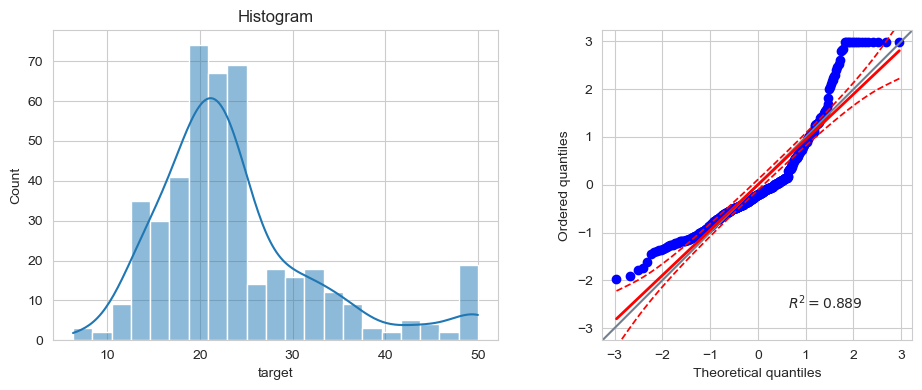

before apply transformation  | skewness: 1.3 | kurtosis: 1.67




In [36]:
def calculate_skew_kurtosis(df,col, moment):
  print(f"{moment}  | skewness: {df[col].skew().round(2)} | kurtosis: {df[col].kurtosis().round(2)}")


def distribution_before_applying_transformer(df):
  for col in df.columns:
    print(f"*** {col} ***")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    sns.histplot(data=df, x=col, kde=True, ax=axes[0])
    axes[0].set_title("Histogram")
    pg.qqplot(df[col], dist='norm',ax=axes[1])
    plt.tight_layout()
    plt.show()
    calculate_skew_kurtosis(df,col,'before apply transformation')
    print("\n")

distribution_before_applying_transformer(df)

We set the pipeline with this transformer: `vt.LogTransformer()`. Then we `.fit_transform()` the pipeline, assigning the result to `df_transformed`

In [43]:
from feature_engine.imputation import DropMissingData

In [47]:
pipeline = Pipeline([
    ('drop_na', DropMissingData()),
      ( 'log', vt.LogTransformer() )
  ])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,DIS,LSTAT,target
0,1.408545,1.605430,3.178054
1,1.602836,2.212660,3.072693
2,1.602836,1.393766,3.546740
3,1.802073,1.078410,3.508556
4,1.802073,1.673351,3.589059


We now compare the distribution of the variables before and after applying the transformer. We create a custom function for that. It plots the histogram and QQplot for the same variable before and after applying the transformer.

Note: When transforming variables, the summary statistics may change. We will consider here only skewness and kurtosis. What is important is to reach a gain where the transformed variable is closer to a normal distribution.

Let's comment on the plots
* `DIS` decreased skewness, but its kurtosis increased and changed from positive to negative. The QQ plot is closer to the diagonal line after transformation, but it is still "bent".
* `LSTAT` decreased skewness and changed from positive to negative. Its kurtosis decreased and changed from positive to negative. The QQ plot is closer to the diagonal line after transformation.
* `target` decreased skewness and kurtosis. Skewness changed from positive to negative, but it is still "bent".

We can say that, in general, this transformation helped to transform these variables to become closer to a normal distribution when we compare the distribution shape and QQ plot before and after applying the transformer.

However, we have more mathematical functions at our disposal to test. 
* That leads to another question: Which mathematical function should I apply to my variable? We prepared a custom function that will use all possible transformations in a given variable, so you can have a report to decide which transformer to apply.


*** DIS ***


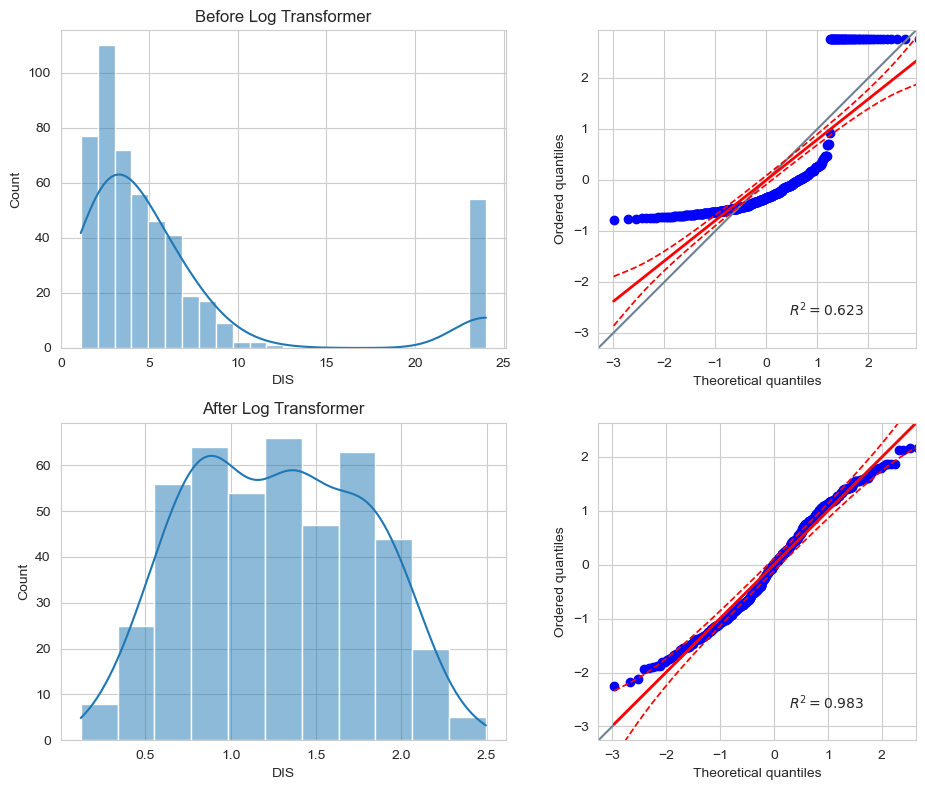

before transformation  | skewness: 2.14 | kurtosis: 3.26
after transformation  | skewness: 0.06 | kurtosis: -0.91


*** LSTAT ***


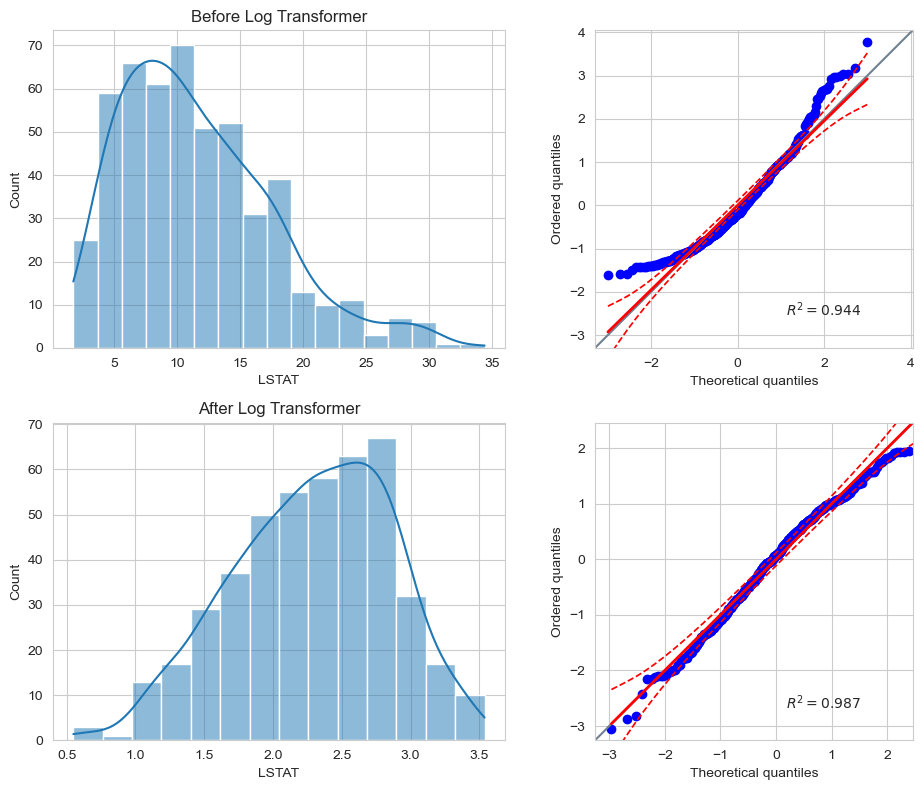

before transformation  | skewness: 0.9 | kurtosis: 0.65
after transformation  | skewness: -0.32 | kurtosis: -0.39


*** target ***


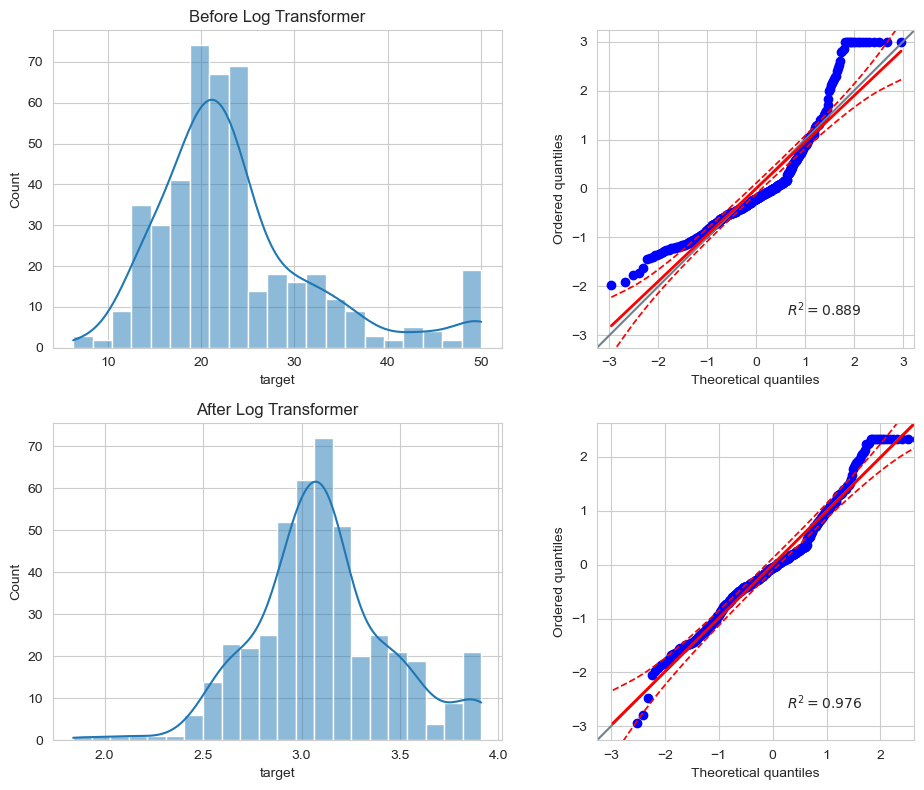

before transformation  | skewness: 1.3 | kurtosis: 1.67
after transformation  | skewness: 0.16 | kurtosis: 0.63




In [50]:
def compare_distributions_before_and_after_applying_transformer(df, df_transformed, method):

  for col in df.columns:
    print(f"*** {col} ***")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

    sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Before {method}')
    pg.qqplot(df[col], dist='norm',ax=axes[0,1])
    
    sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'After {method}')
    pg.qqplot(df_transformed[col], dist='norm',ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

    calculate_skew_kurtosis(df,col, moment='before transformation')
    calculate_skew_kurtosis(df_transformed,col, moment='after transformation')
    print("\n")


compare_distributions_before_and_after_applying_transformer(df, df_transformed, method='Log Transformer')

## Reciprocal Transformer

This technique applies the reciprocal transformation 1 / x to numerical variables. As we may expect, it can't handle a variable that contains zero. The function documentation is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/transformation/ReciprocalTransformer.html)
* The argument is `variables`. In cases where you don't pass in a list of variables, the transformer considers all numerical variables.

In [54]:
boston_data = pd.read_csv('housing.csv')
df = pd.DataFrame(data=boston_data)
df['target'] = pd.Series(boston_data.target)

df = df.filter(['DIS','LSTAT', 'target'])
df.head()

,DIS,LSTAT,target
0,4.0900,4.98,24.0
1,4.9671,9.14,21.6
2,4.9671,4.03,34.7
3,6.0622,2.94,33.4
4,6.0622,5.33,36.2


We assess the distribution using the previous custom function.

*** DIS ***


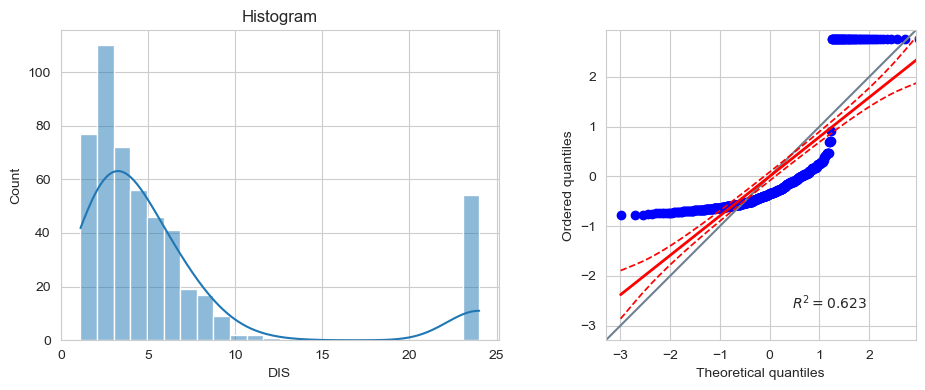

before apply transformation  | skewness: 2.14 | kurtosis: 3.26


*** LSTAT ***


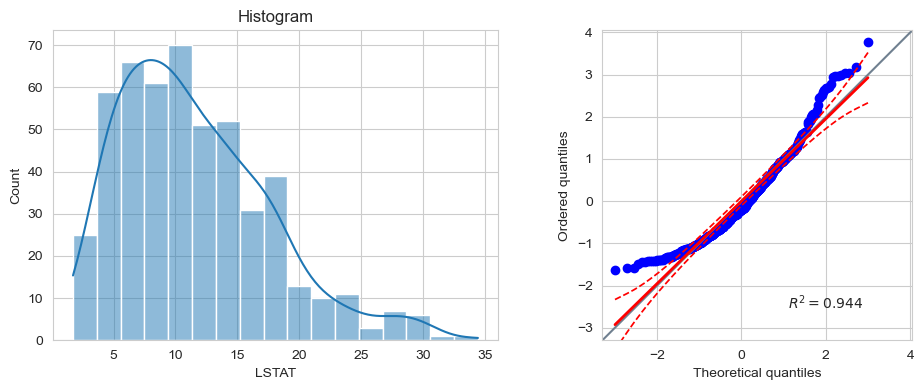

before apply transformation  | skewness: 0.9 | kurtosis: 0.65


*** target ***


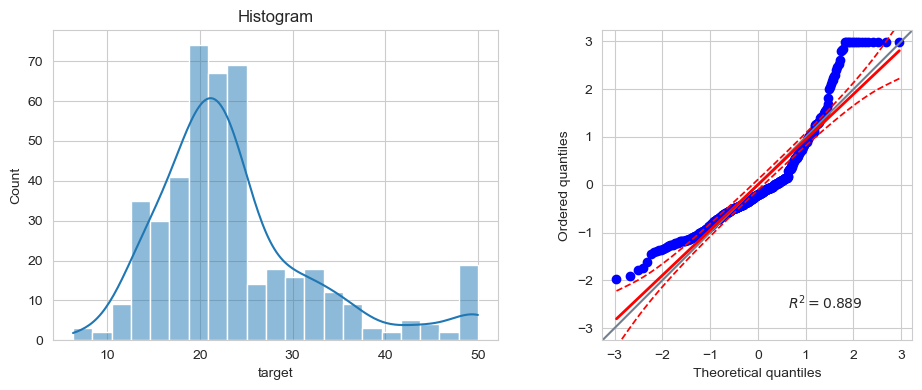

before apply transformation  | skewness: 1.3 | kurtosis: 1.67




In [56]:
distribution_before_applying_transformer(df)

We set the pipeline with this transformer: `vt.ReciprocalTransformer()`. Then we `.fit_transform()` the pipeline, assigning the result to `df_transformed`

In [62]:
pipeline = Pipeline([
    ('drop_na', DropMissingData()),
    ('reciprocal', vt.ReciprocalTransformer() )
  ])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,DIS,LSTAT,target
0,0.244499,0.200803,0.041667
1,0.201325,0.109409,0.046296
2,0.201325,0.248139,0.028818
3,0.164957,0.340136,0.029940
4,0.164957,0.187617,0.027624


We compare the histograms and QQ plots before and after applying the transformers.

Let's comment on the plots.
* ``DIS`` decreased skewness, and kurtosis changed from positive to negative. The QQ plots look similar. It doesn't look to have made any progress after transforming.
* `LSTAT` increases both skewness and kurtosis. It doesn't look to have made any progress after transforming.
* `target` increases both skewness and kurtosis. It doesn't look to have made any progress after transforming.


*** DIS ***


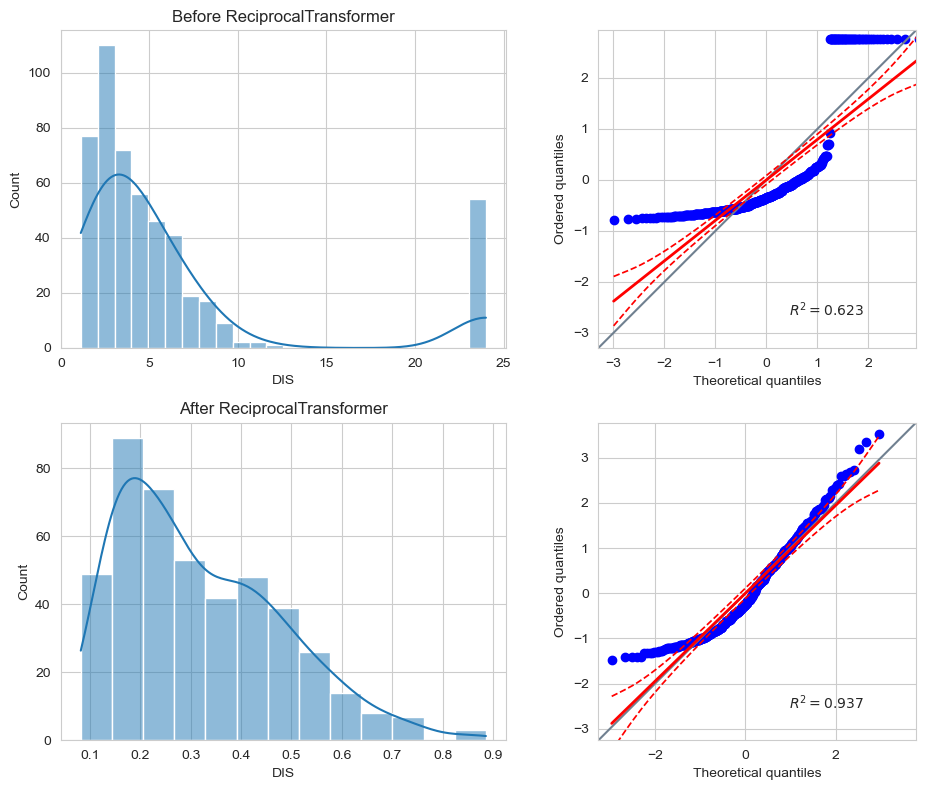

before transformation  | skewness: 2.14 | kurtosis: 3.26
after transformation  | skewness: 0.8 | kurtosis: 0.09


*** LSTAT ***


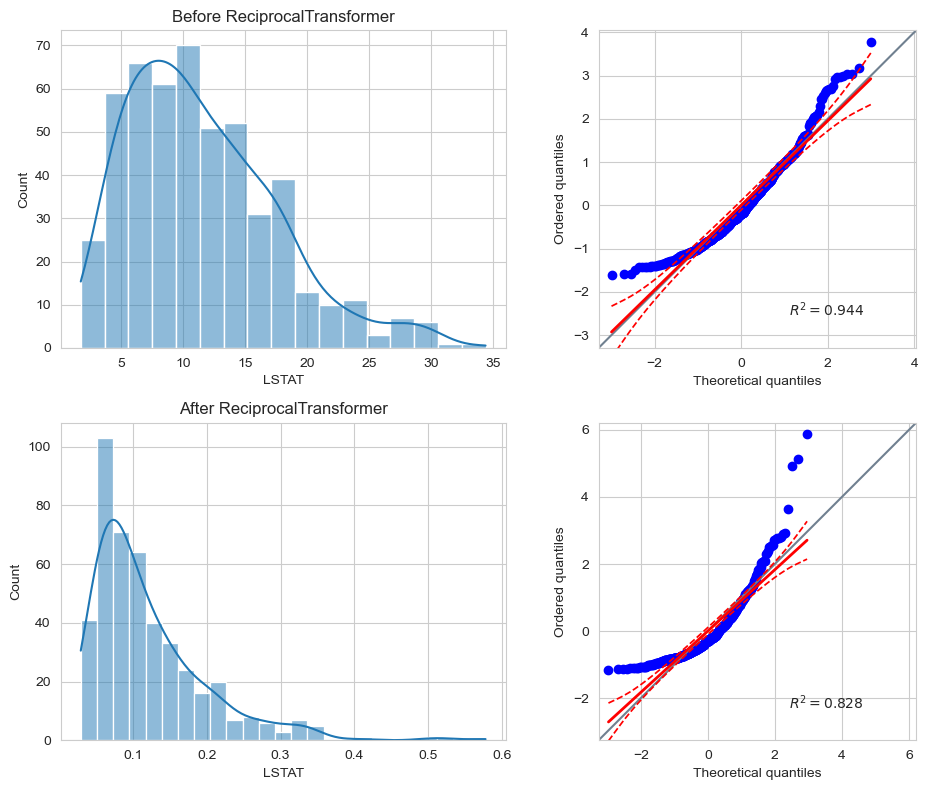

before transformation  | skewness: 0.9 | kurtosis: 0.65
after transformation  | skewness: 1.92 | kurtosis: 5.39


*** target ***


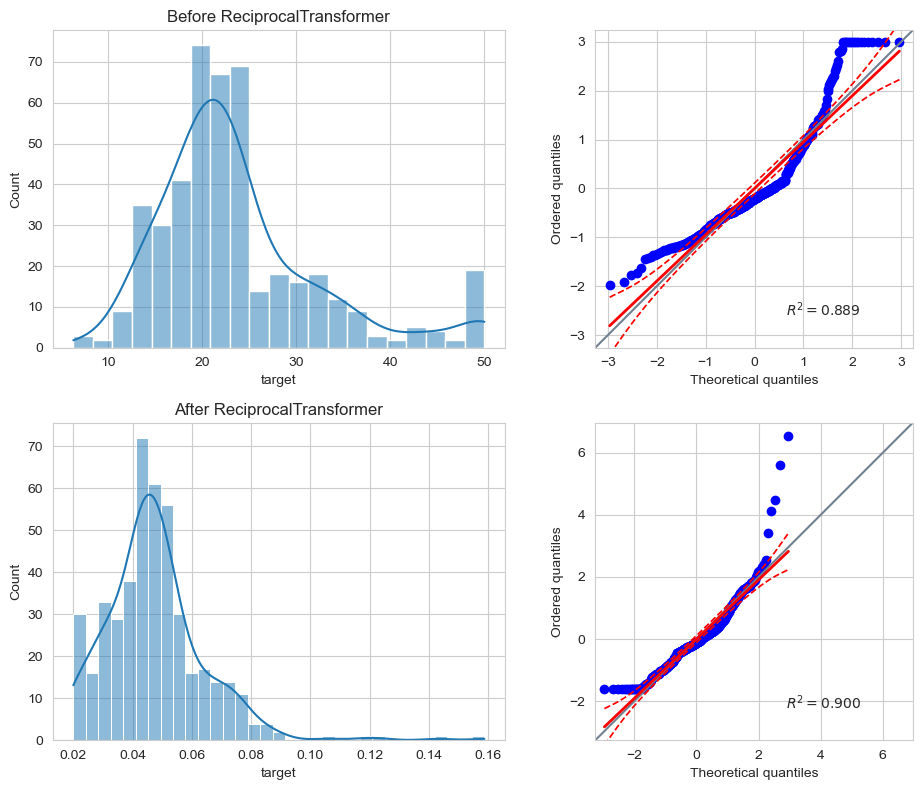

before transformation  | skewness: 1.3 | kurtosis: 1.67
after transformation  | skewness: 1.61 | kurtosis: 6.78




In [65]:
compare_distributions_before_and_after_applying_transformer(df, df_transformed, method='ReciprocalTransformer')

## Box Cox Transformer

It applies the BoxCox transformation to numerical variables. A mathematical formulation can be found [here](https://www.statisticshowto.com/box-cox-transformation/). The data must be positive for the transformer. The documentation for the function is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/transformation/BoxCoxTransformer.html)
* The argument is `variables`. In cases where you don't pass in a list of variables, the transformer considers all numerical variables. 

In [68]:
boston_data = pd.read_csv('housing.csv')
df = pd.DataFrame(data=boston_data)
df['target'] = pd.Series(boston_data.target)

df = df.filter(['DIS','LSTAT', 'target'])
df.head()

,DIS,LSTAT,target
0,4.0900,4.98,24.0
1,4.9671,9.14,21.6
2,4.9671,4.03,34.7
3,6.0622,2.94,33.4
4,6.0622,5.33,36.2


We assess the distribution using the previous custom function.

*** DIS ***


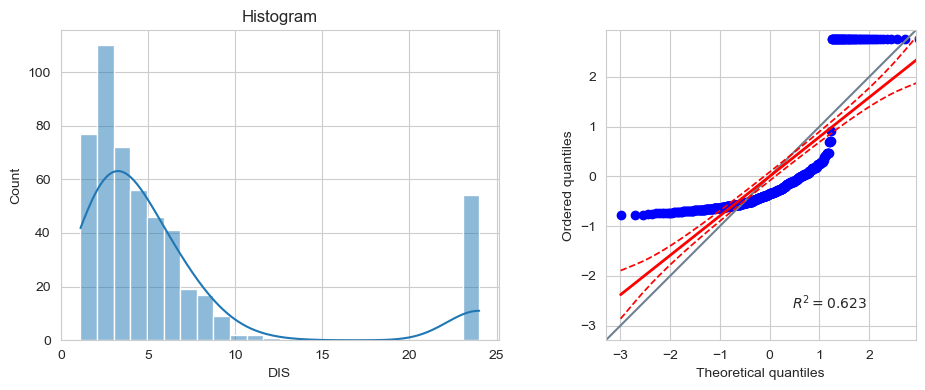

before apply transformation  | skewness: 2.14 | kurtosis: 3.26


*** LSTAT ***


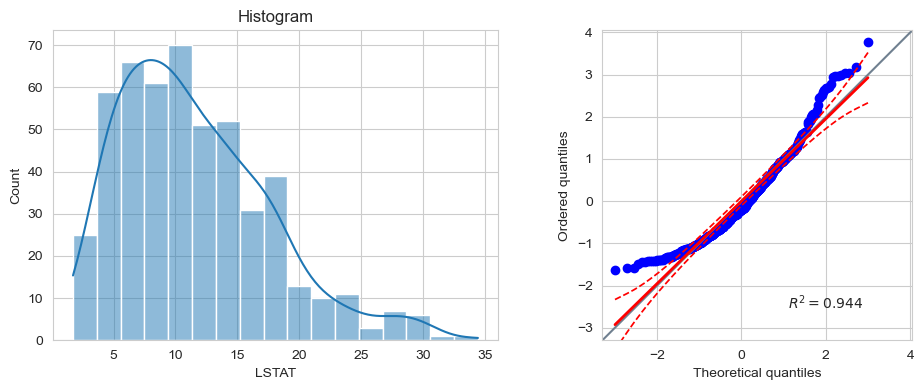

before apply transformation  | skewness: 0.9 | kurtosis: 0.65


*** target ***


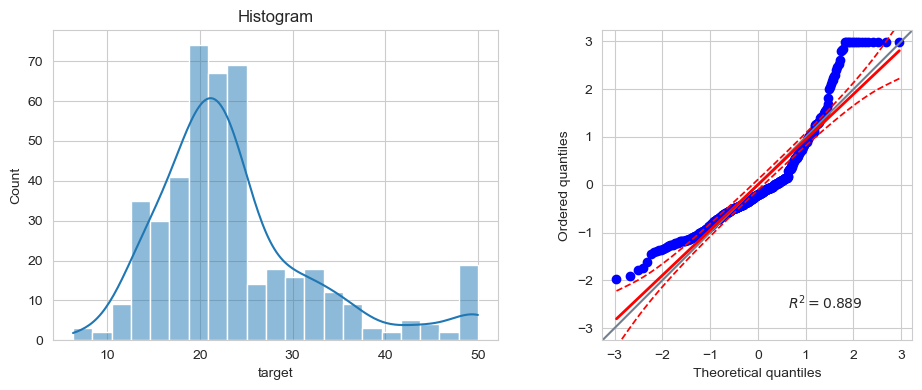

before apply transformation  | skewness: 1.3 | kurtosis: 1.67




In [70]:
distribution_before_applying_transformer(df)

In [73]:
pipeline = Pipeline([
    ('drop_na', DropMissingData()),
      ('bct', vt.BoxCoxTransformer() )
  ])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,DIS,LSTAT,target
0,1.350255,1.956623,2.617291
1,1.527647,2.915457,2.546313
2,1.527647,1.653769,2.858352
3,1.707404,1.230016,2.833904
4,1.707404,2.057097,2.885310


We compare the histograms and QQ plots before and after applying the transformers.

Let's comment on the plots.
* `DIS` decreased skewness, kurtosis changed from positive to negative. The QQ plots look similar. It doesn't look to have made any progress after transforming.
* `LSTAT` decreased skewness, and kurtosis changed from positive to negative. It looks to have made an improvement when you look at the QQ plot.
* `target` decreased skewness and kurtosis. It looks to have made minor progress when comparing the QQ plot before and after the transformation since the blue dots are close to the diagonal line.


*** DIS ***


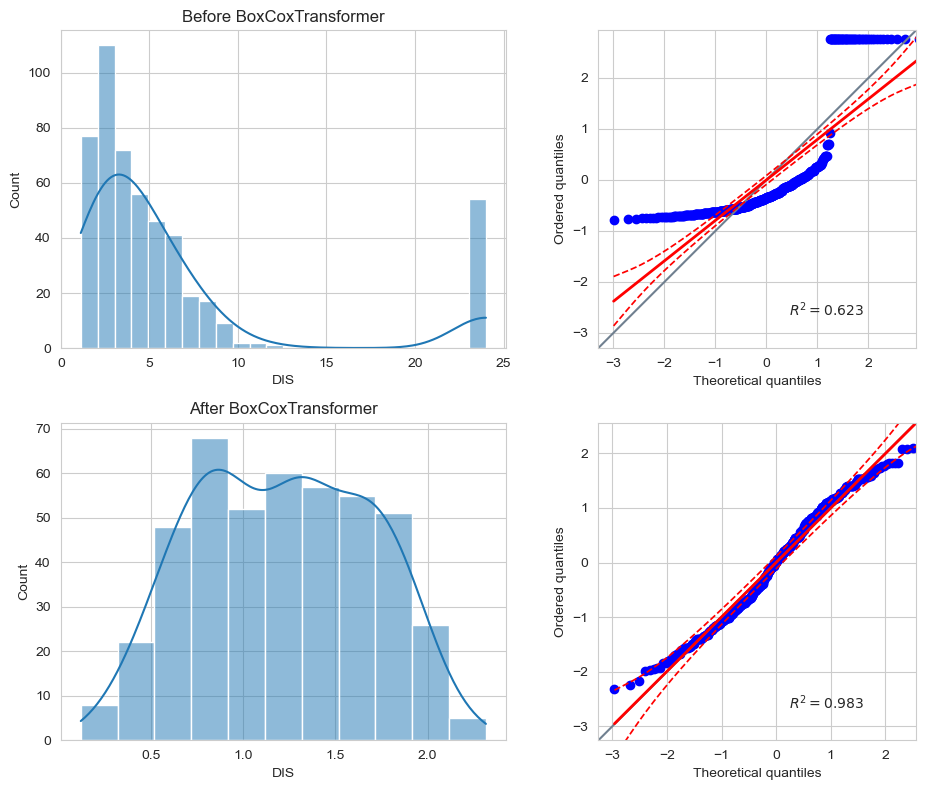

before transformation  | skewness: 2.14 | kurtosis: 3.26
after transformation  | skewness: 0.01 | kurtosis: -0.91


*** LSTAT ***


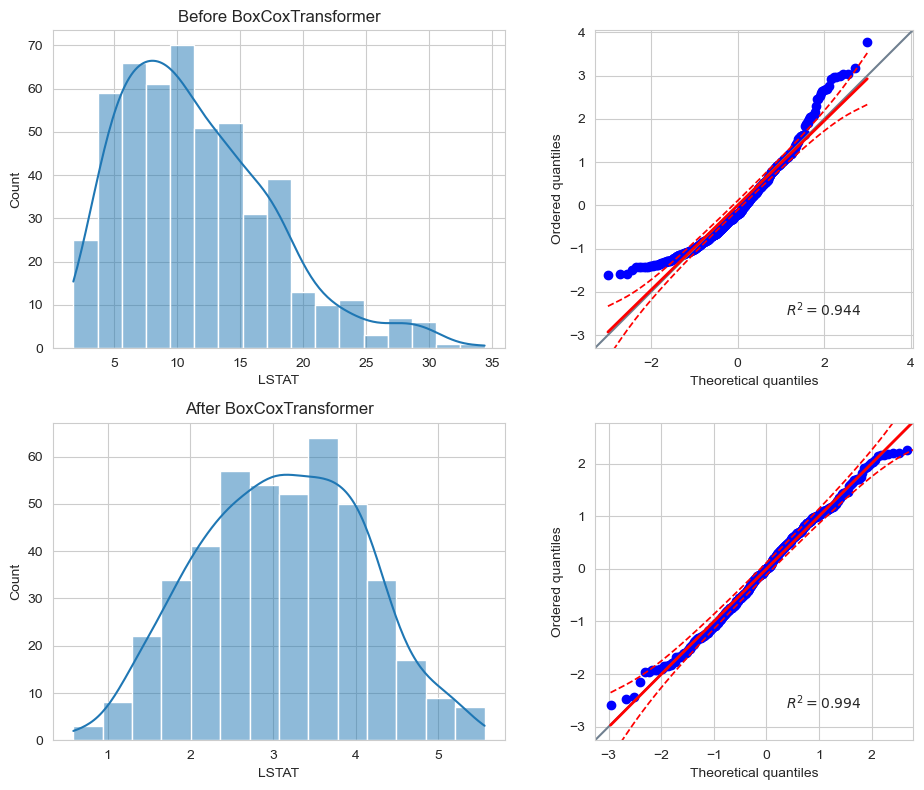

before transformation  | skewness: 0.9 | kurtosis: 0.65
after transformation  | skewness: -0.03 | kurtosis: -0.55


*** target ***


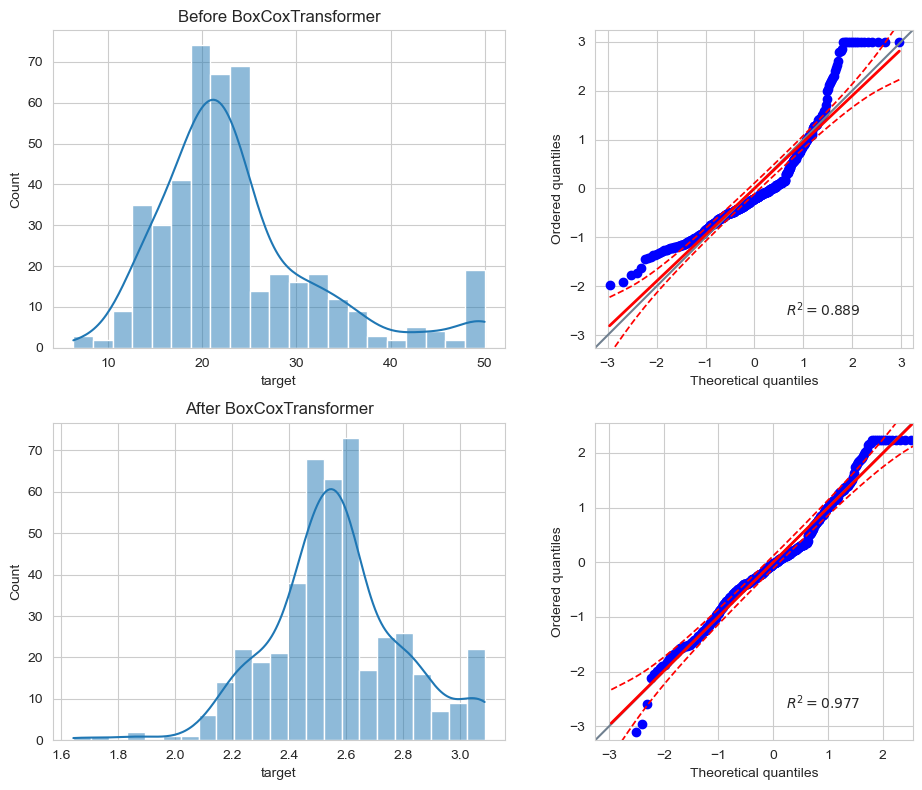

before transformation  | skewness: 1.3 | kurtosis: 1.67
after transformation  | skewness: -0.01 | kurtosis: 0.8




In [76]:
compare_distributions_before_and_after_applying_transformer(df, df_transformed, method='BoxCoxTransformer')

## Yeo Johnson Transformer

It applies the Yeo-Johnson transformation. More information on the mathematical formulation can be found [here](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/). The documentation for the function is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/transformation/YeoJohnsonTransformer.html).
* The argument is a list of `variables`. In cases where you don't pass in a list of variables, the transformer considers all numerical variables. 

In [79]:
boston_data = pd.read_csv('housing.csv')
df = pd.DataFrame(data=boston_data)
df['target'] = pd.Series(boston_data.target)

df = df.filter(['DIS','LSTAT', 'target'])
df.head()

,DIS,LSTAT,target
0,4.0900,4.98,24.0
1,4.9671,9.14,21.6
2,4.9671,4.03,34.7
3,6.0622,2.94,33.4
4,6.0622,5.33,36.2


*** DIS ***


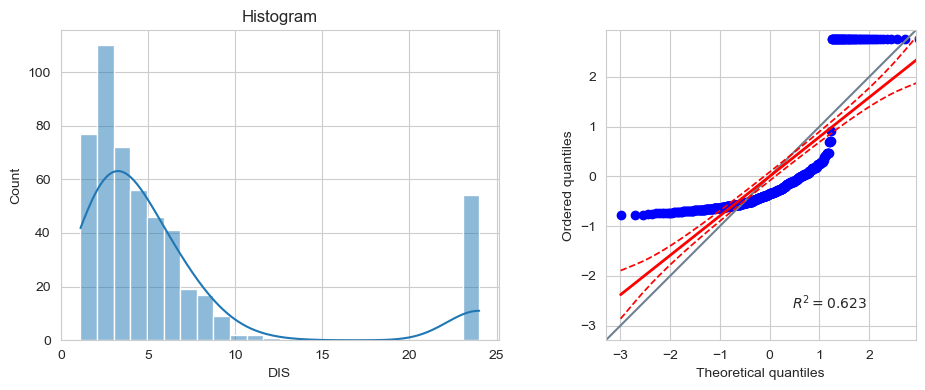

before apply transformation  | skewness: 2.14 | kurtosis: 3.26


*** LSTAT ***


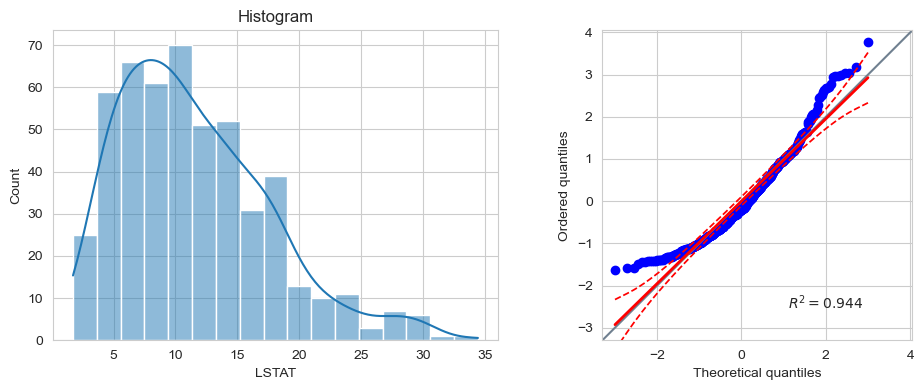

before apply transformation  | skewness: 0.9 | kurtosis: 0.65


*** target ***


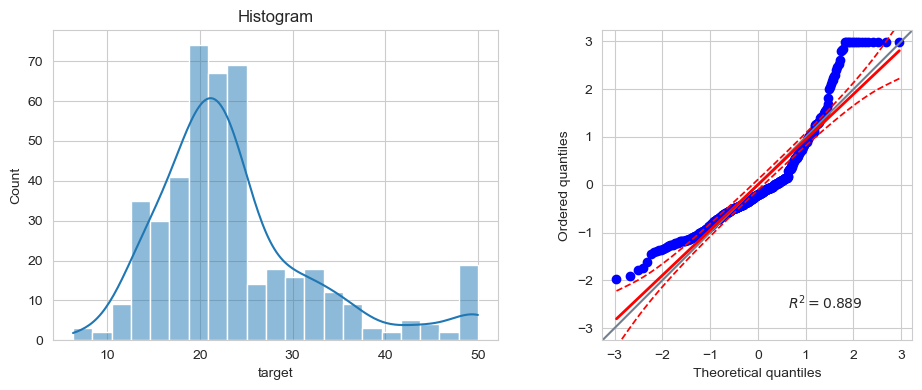

before apply transformation  | skewness: 1.3 | kurtosis: 1.67




In [81]:
distribution_before_applying_transformer(df)

In [83]:
pipeline = Pipeline([
    ('drop_na', DropMissingData()),
    ('yj', vt.YeoJohnsonTransformer() )
  ])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,DIS,LSTAT,target
0,1.270068,2.070421,2.416483
1,1.362421,2.803882,2.360774
2,1.362421,1.843292,2.604919
3,1.455330,1.533148,2.585882
4,1.455330,2.146480,2.625888


We compare the histograms and QQ plots before and after applying the transformers.

Let's comment on the plots.
* `DIS` decreased skewness, and kurtosis increased and changed from positive to negative. The QQ plots look to have made progress since the blue dots are closer to the diagonal line.
* `LSTAT`: same as above.
* `target` decreased skewness and kurtosis. The QQ plot after the transformation looks better than before the transformation.


*** DIS ***


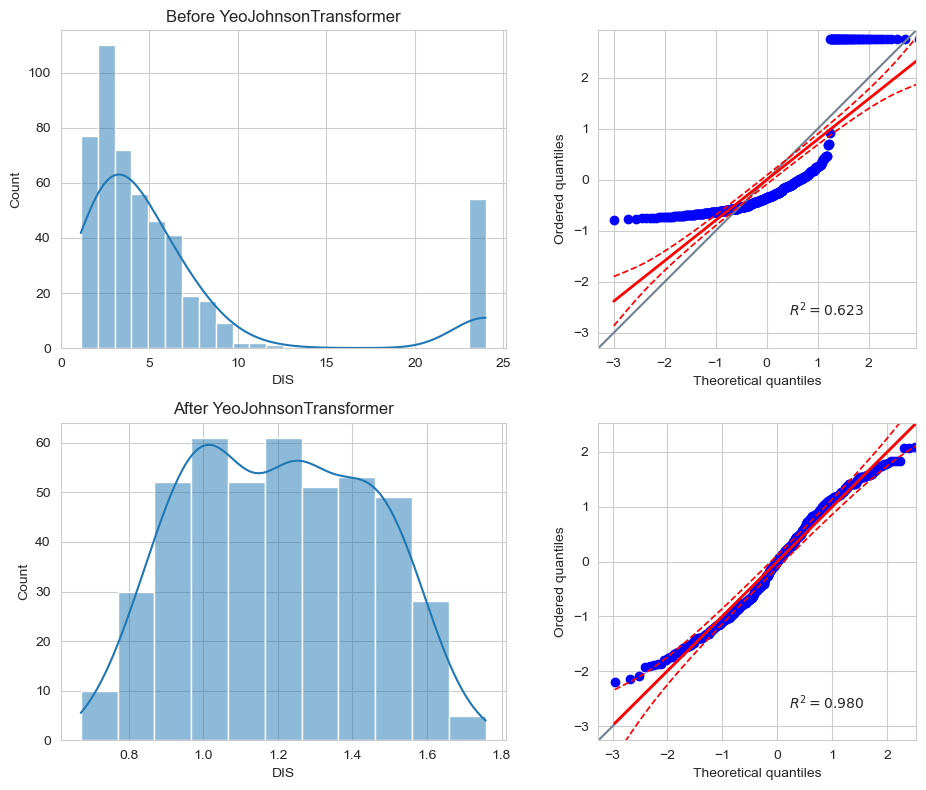

before transformation  | skewness: 2.14 | kurtosis: 3.26
after transformation  | skewness: 0.04 | kurtosis: -0.97


*** LSTAT ***


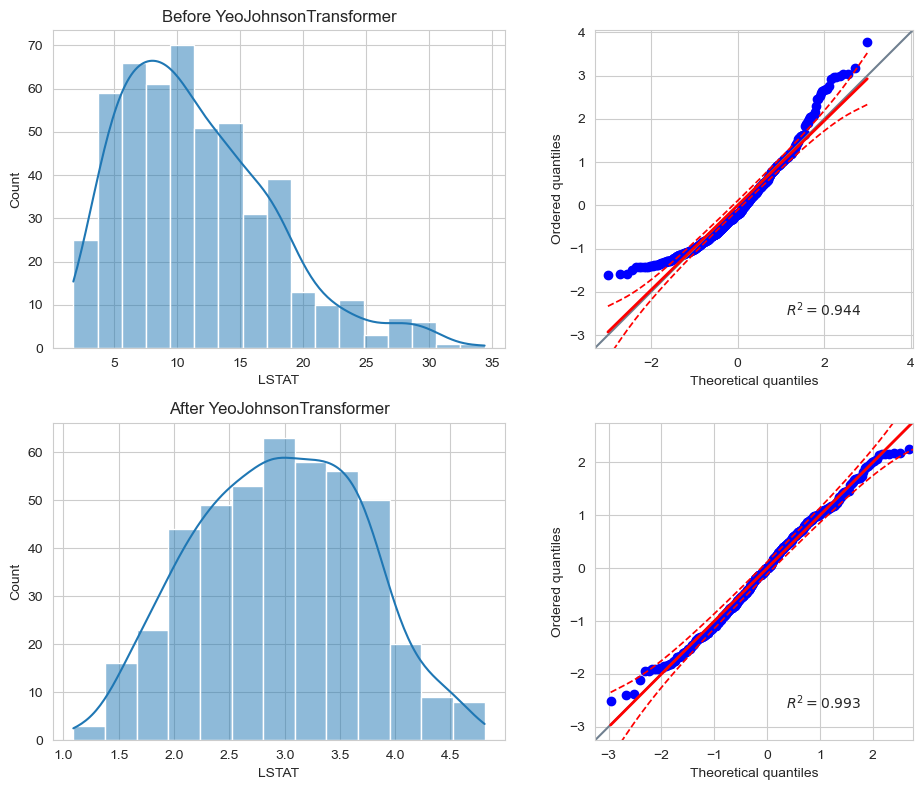

before transformation  | skewness: 0.9 | kurtosis: 0.65
after transformation  | skewness: -0.02 | kurtosis: -0.6


*** target ***


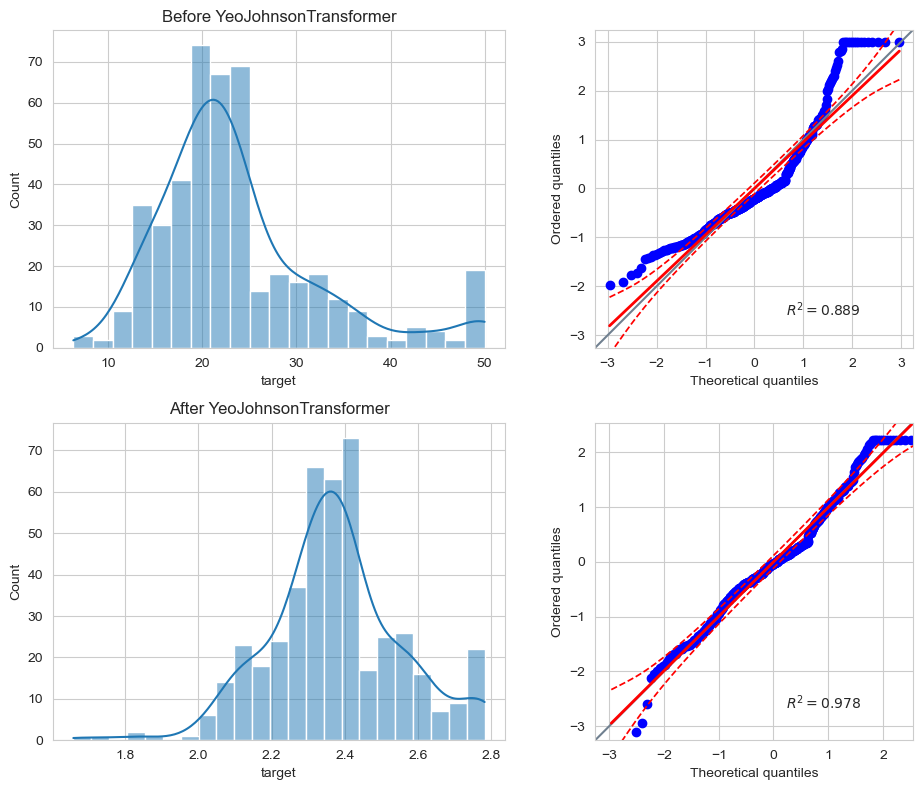

before transformation  | skewness: 1.3 | kurtosis: 1.67
after transformation  | skewness: -0.01 | kurtosis: 0.76




In [87]:
compare_distributions_before_and_after_applying_transformer(df, df_transformed, method='YeoJohnsonTransformer')